In [1]:
# 📌 1. Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [2]:
# 📌 2. Load and Explore Data
df = pd.read_csv('C:/Users/USER/Documents/Smarthelioassingmentsolution/SampleData.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.dropna()

In [3]:
# 📌 3. Feature Engineering
df['Delta_P'] = df['P_exp'] - df['P']
df['Ratio_P'] = df['P'] / df['P_exp'].replace(0, 1)
df['P_diff'] = df['P'].diff().fillna(0)
df['P_exp_diff'] = df['P_exp'].diff().fillna(0)
df['Rolling_Mean'] = df['Delta_P'].rolling(window=10, min_periods=1).mean()
df['Rolling_Std'] = df['Delta_P'].rolling(window=10, min_periods=1).std().fillna(0)

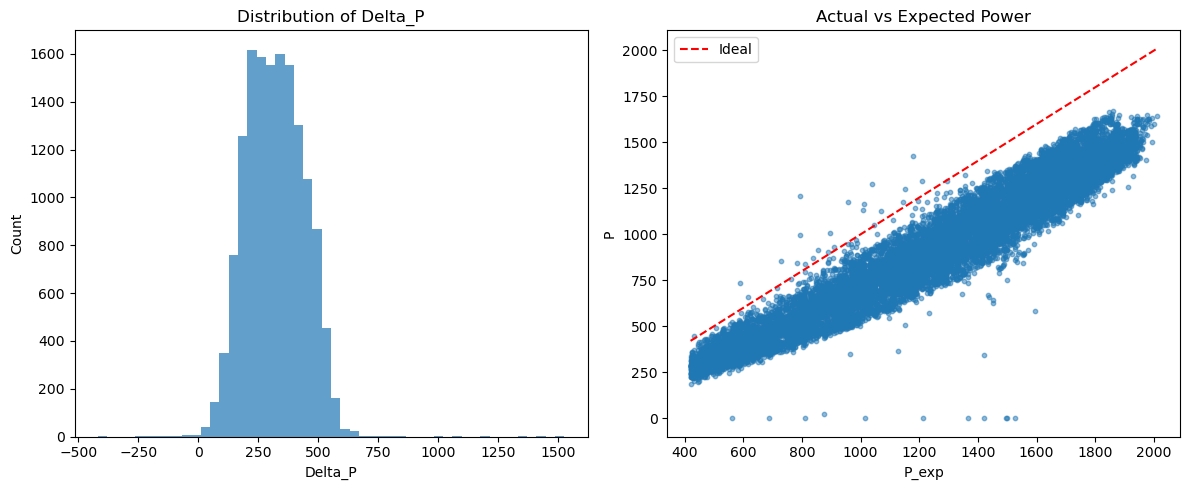

In [4]:
# 📌 4. Visualize Data Distribution and Feature Relationships
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Delta_P'], bins=50, alpha=0.7)
plt.title('Distribution of Delta_P')
plt.xlabel('Delta_P')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.scatter(df['P_exp'], df['P'], alpha=0.5, s=10)
plt.plot([df['P_exp'].min(), df['P_exp'].max()],
         [df['P_exp'].min(), df['P_exp'].max()], 'r--', label='Ideal')
plt.title('Actual vs Expected Power')
plt.xlabel('P_exp')
plt.ylabel('P')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# 📌 5. Prepare Features for Modeling
features = df[['Delta_P', 'Ratio_P', 'P_diff', 'P_exp_diff', 'Rolling_Mean', 'Rolling_Std']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [6]:
# 📌 6. Model 1: Isolation Forest
model_if = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_if'] = model_if.fit_predict(features_scaled)
df['anomaly_if'] = df['anomaly_if'].map({1: 0, -1: 1})

In [7]:
# 📌 7. Model 2: Local Outlier Factor
model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
df['anomaly_lof'] = model_lof.fit_predict(features_scaled)
df['anomaly_lof'] = df['anomaly_lof'].map({1: 0, -1: 1})

In [8]:
# 📌 8. Model 3: One-Class SVM
model_ocsvm = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')
df['anomaly_ocsvm'] = model_ocsvm.fit_predict(features_scaled)
df['anomaly_ocsvm'] = df['anomaly_ocsvm'].map({1: 0, -1: 1})

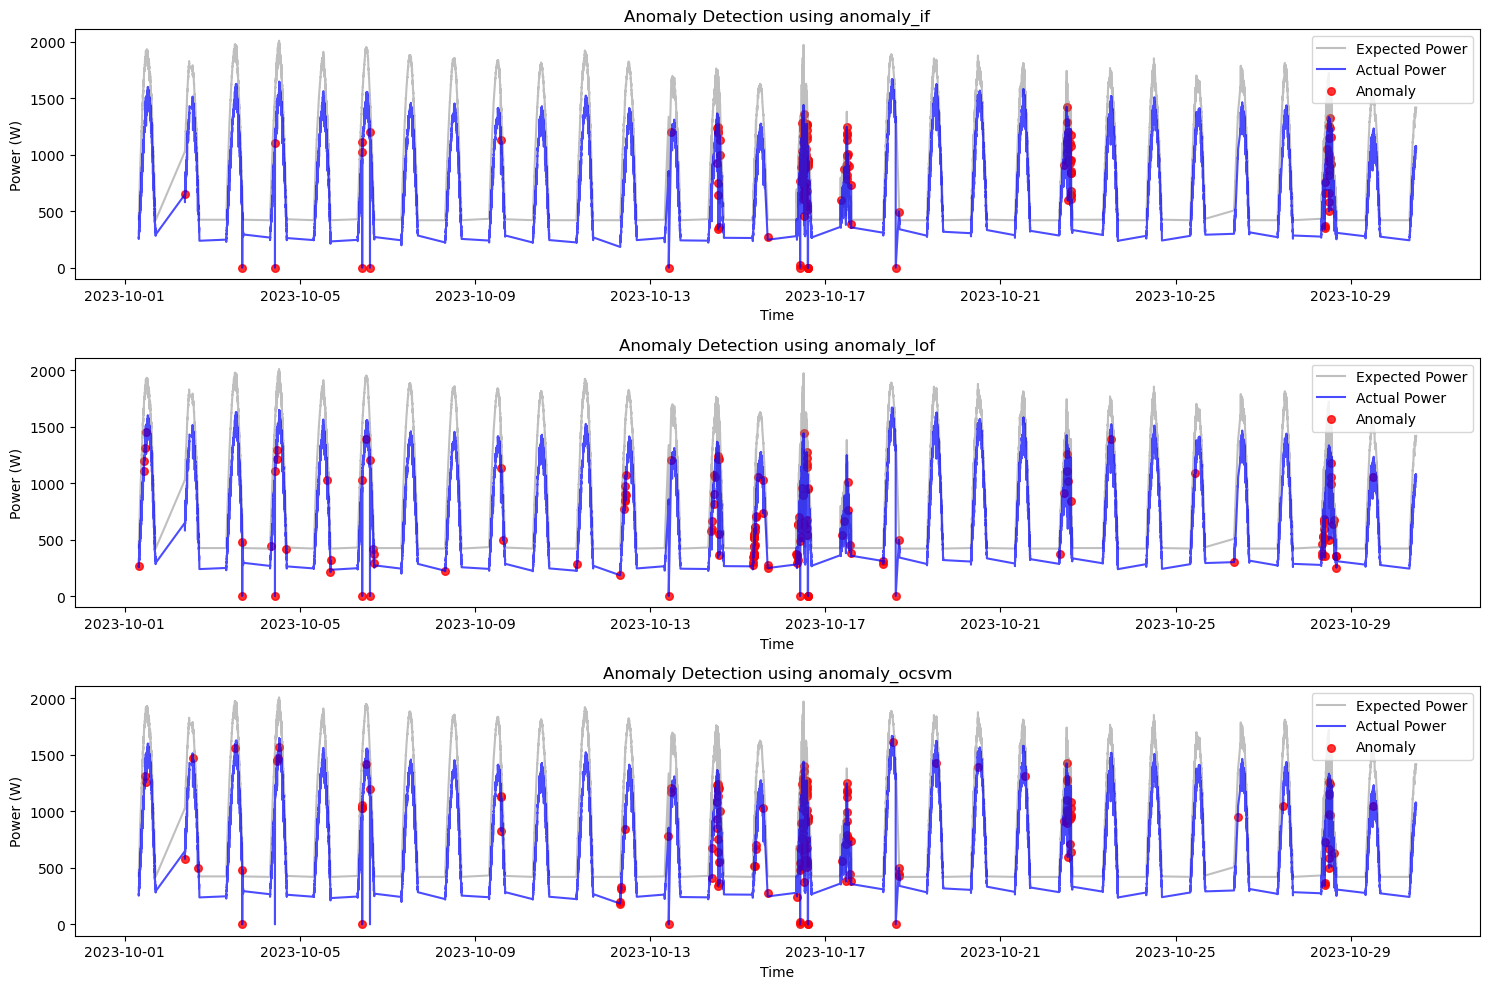

In [9]:
# 📌 9. Visualize Anomalies Detected by Each Model
plt.figure(figsize=(15, 10))
for i, model in enumerate(['anomaly_if', 'anomaly_lof', 'anomaly_ocsvm']):
    plt.subplot(3, 1, i+1)
    plt.plot(df.index, df['P_exp'], label='Expected Power', color='gray', alpha=0.5)
    plt.plot(df.index, df['P'], label='Actual Power', color='blue', alpha=0.7)
    plt.scatter(df.index[df[model] == 1], df['P'][df[model] == 1],
                color='red', s=30, label='Anomaly', alpha=0.8)
    plt.title(f'Anomaly Detection using {model}')
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 📌 10. Compare Model Results
anomaly_counts = {
    'Isolation Forest': df['anomaly_if'].sum(),
    'Local Outlier Factor': df['anomaly_lof'].sum(),
    'One-Class SVM': df['anomaly_ocsvm'].sum()
}
print("Anomaly counts per model:", anomaly_counts)

Anomaly counts per model: {'Isolation Forest': np.int64(145), 'Local Outlier Factor': np.int64(145), 'One-Class SVM': np.int64(170)}


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=3b51d56401dc067f57e21e9c84d140c152420b72714a0e4528c4009267c29c0c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\d1\5f\e6\771479559f992b8398265ebf61f8a3d33ca0b8f75552e06ad2
Successfully built matplotlib-venn


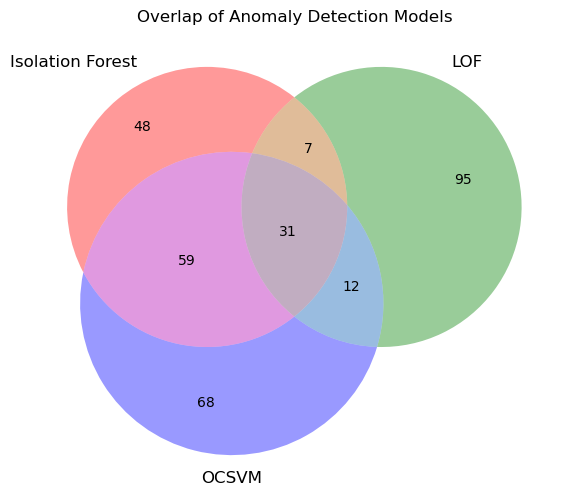

In [12]:
# 📌 11. Venn Diagram of Anomaly Overlap (optional, requires matplotlib-venn)
!pip install matplotlib-venn
from matplotlib_venn import venn3
set_if = set(df.index[df['anomaly_if'] == 1])
set_lof = set(df.index[df['anomaly_lof'] == 1])
set_ocsvm = set(df.index[df['anomaly_ocsvm'] == 1])
plt.figure(figsize=(8, 6))
venn3([set_if, set_lof, set_ocsvm], ('Isolation Forest', 'LOF', 'OCSVM'))
plt.title("Overlap of Anomaly Detection Models")
plt.show()

In [13]:
# 📌 12. Detailed Inspection: Show Top Anomalies
top_anomalies = df[df['anomaly_if'] == 1].sort_values('Delta_P', ascending=False).head(10)
print("Top anomalies detected by Isolation Forest:")
print(top_anomalies[['P_exp', 'P', 'Delta_P', 'Ratio_P']])

Top anomalies detected by Isolation Forest:
                         P_exp       P    Delta_P   Ratio_P
Datetime                                                   
2023-10-04 10:20:00  1524.7680    0.00  1524.7680  0.000000
2023-10-06 14:25:00  1500.1350    0.00  1500.1350  0.000000
2023-10-06 10:09:00  1496.0295    0.00  1496.0295  0.000000
2023-10-18 14:34:00  1422.1305    0.00  1422.1305  0.000000
2023-10-16 14:26:00  1364.6535    0.00  1364.6535  0.000000
2023-10-16 14:30:00  1212.7500    0.00  1212.7500  0.000000
2023-10-14 13:16:00  1422.1305  342.20  1079.9305  0.240625
2023-10-16 14:27:00  1015.6860    0.00  1015.6860  0.000000
2023-10-28 12:02:00  1594.5615  584.66  1009.9015  0.366659
2023-10-16 10:13:00   876.0990   22.40   853.6990  0.025568


In [14]:
# 📌 14. Model Comparison Table
comparison = pd.DataFrame({
    'IsolationForest': df['anomaly_if'],
    'LOF': df['anomaly_lof'],
    'OCSVM': df['anomaly_ocsvm']
})
print("Anomaly detection agreement (rows where all models agree):")
print(comparison[(comparison == 1).all(axis=1)].shape[0], "points")

Anomaly detection agreement (rows where all models agree):
31 points


In [15]:
# 📌 15. Summary and Recommendations
print("""
Summary:
- Isolation Forest, LOF, and One-Class SVM were applied to engineered PV data features.
- All models flag rare, significant deviations as anomalies, but may differ on marginal cases.
- Use visualizations to validate flagged anomalies against domain knowledge.
- For production, ensemble or majority-vote of models can improve robustness.
""")


Summary:
- Isolation Forest, LOF, and One-Class SVM were applied to engineered PV data features.
- All models flag rare, significant deviations as anomalies, but may differ on marginal cases.
- Use visualizations to validate flagged anomalies against domain knowledge.
- For production, ensemble or majority-vote of models can improve robustness.

